In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor



In [2]:
df_disks = pd.read_csv('Disks Dataset_as defined in notebook v13')

In [3]:
X_disks = df_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_disks = df_disks.loc[:,'GalpropNormHalfRadius']

In [4]:
df_disks_sample = df_disks.sample(n = 7000, random_state = 2022) #choose a subset of randomly sampled data

In [5]:
df_disks_2000_sample = df_disks.sample(n = 1990, random_state = 2022)

In [6]:
df_disks_2000_sample = df_disks_2000_sample.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormHalfRadius' ]]

In [7]:
df_disks_2000_sample.to_csv('df_disks_2000_sample')

In [8]:
df_disks_2000_sample.shape

(1990, 5)

In [9]:
# choose the 7 most important features from analysis above to be used for SR modelling

X_disks_imp = df_disks_sample.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar', 'BulgeMstar_ratio']]


y_disks_imp = df_disks_sample.loc[:, 'GalpropNormHalfRadius']

In [10]:
# choose the Symbolic Regression model; choose the mathematical operations allowed
model_disks_imp = PySRRegressor(

    niterations=10,
    binary_operators=["+", "*", "pow", "/" , "mylogfunc(x,y)=log(1-(x/y))" ],
    extra_sympy_mappings={'mylogfunc': lambda x, y: log(1-(x/y))},
    
    unary_operators=["exp", "square", "cube", "log10_abs"
#         "inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    constraints={
        "pow": (-1, 1),
        "/": (-1, 4),
#         "sqrt": 5,
    },
    nested_constraints={
        "pow": {"pow": 1, "exp": 0},
#         "square": {"square": 1, "cube": 1, "exp": 0},
#         "cube": {"square": 1, "cube": 1, "exp": 0},
#         "exp": {"square": 1, "cube": 1, "exp": 0},
    },
    
    maxsize=20,
    multithreading=False,
    model_selection="accuracy", # Result is mix of simplicity+accuracy
    loss="loss(x, y) = (x - y)^2"  # Custom loss function (julia syntax)
)

In [21]:
print(model_disks_imp.sympy())

(979.44867*HalopropSpin + 1.72821520949907*exp(2*exp(-132597.683634735*HalopropSpin**3)))/GalpropNormVdisk**2


In [ ]:
# best eqn with n_iter=100 and n_iter=500, and new eqn grid including division
1054.8468*HalopropSpin/GalpropNormVdisk**2


In [ ]:
# best eqn with n_iter=10 , and new eqn grid including division and log10

(979.44867*HalopropSpin + 1.72821520949907*exp(2*exp(-132597.683634735*HalopropSpin**3)))/GalpropNormVdisk**2

In [24]:
eqn = (979.44867*X_disks_imp.loc[:,'HalopropSpin'] + 1.72821520949907*np.exp(2*np.exp(-132597.683634735*X_disks_imp.loc[:,'HalopropSpin']**3)))/X_disks_imp.loc[:, 'GalpropNormVdisk']**2

In [34]:
eqn = 1054.8468*X_disks_imp.loc[:,'HalopropSpin']/(X_disks_imp.loc[:, 'GalpropNormVdisk'])**2

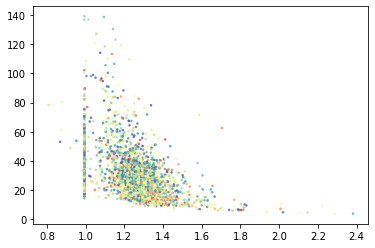

In [32]:
plt.scatter(X_disks_imp.loc[:, 'GalpropNormVdisk'], eqn,
            c = df_disks_sample['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7)

In [28]:
r2_score_disks=r2_score(y_disks_imp, model_disks_imp.predict(X_disks_imp))

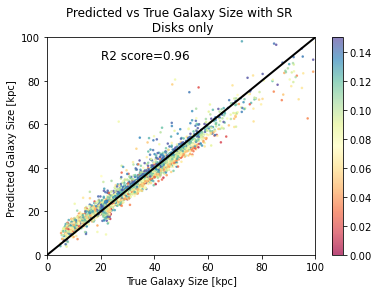

In [30]:
plt.scatter(y_disks_imp, model_disks_imp.predict(X_disks_imp),
            c = df_disks_sample['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Disks only')
plt.xlabel('True Galaxy Size [kpc]')
plt.ylabel('Predicted Galaxy Size [kpc] ')
plt.colorbar()
# plt.savefig('SR_disks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [24]:
# (0.07023443 + 1016.5274*HalopropSpin**2/GalpropNormVdisk**2)/(GalpropNormMH2 + HalopropSpin)
eqn1= (1016.5274*df_disks_sample['HalopropSpin']**2/df_disks_sample['GalpropNormVdisk']**2)/(df_disks_sample['GalpropNormMH2'] + df_disks_sample['HalopropSpin'])

In [25]:
r2_score_disks1=r2_score(y_disks_imp, eqn1)

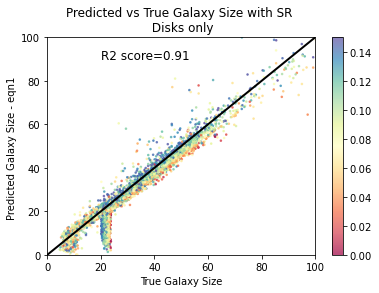

In [26]:
plt.scatter(y_disks_imp, eqn1,
            c = df_disks_sample['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7) #,label= label, vmin=-2, vmax=1.0)
plt.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_disks1), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,100])
plt.title('Predicted vs True Galaxy Size with SR \n Disks only')
plt.xlabel('True Galaxy Size')
plt.ylabel('Predicted Galaxy Size - eqn1 ')
plt.colorbar()
# plt.savefig('SR_disks_predicted vs true gal size.jpeg', dpi=500)
plt.show()

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.read_csv('Disks_equations_n_iter_20000')

,Unnamed: 0,complexity,loss,score,equation,sympy_format,lambda_format
0,0,1,245.492950,0.000000,30.742214,30.7422140000000,PySRFunction(X=>30.7422140000000)
1,1,3,92.863360,0.486070,(HalopropSpin * 803.20526),803.20526*HalopropSpin,PySRFunction(X=>803.20526*HalopropSpin)
2,2,4,91.197105,0.018106,(log1p_abs(HalopropSpin) * 828.21344),828.21344*log(Abs(HalopropSpin) + 1),PySRFunction(X=>828.21344*log(Abs(HalopropSpin) + 1))
3,3,5,37.530350,0.887873,"(pow(HalopropSpin, GalpropNormVdisk) * 1132.2211)",1132.2211*Abs(HalopropSpin)**GalpropNormVdisk,PySRFunction(X=>1132.2211*Abs(HalopropSpin)**GalpropNormVdisk)
4,4,6,18.959124,0.682865,(HalopropSpin * (1055.483 / square(GalpropNormVdisk))),1055.483*HalopropSpin/GalpropNormVdisk**2,PySRFunction(X=>1055.483*HalopropSpin/GalpropNormVdisk**2)
5,5,7,18.644920,0.016712,((HalopropSpin / cube(log1p_abs(GalpropNormVdisk))) * 354.92014),354.92014*HalopropSpin/log(Abs(GalpropNormVdisk) + 1)**3,PySRFunction(X=>354.92014*HalopropSpin/log(Abs(GalpropNormVdisk) + 1)**3)
6,6,8,13.475765,0.324681,square(((HalopropSpin * 65.25555) + 3.720235) / GalpropNormVdisk),4258.2868058025*(HalopropSpin + 0.0570102466380254)**2/GalpropNormVdisk**2,PySRFunction(X=>4258.2868058025*(HalopropSpin + 0.0570102466380254)**2/GalpropNormVdisk**2)
7,7,9,12.459515,0.078408,square(((log1p_abs(HalopropSpin) * 69.69802) + 3.6154892) / GalpropNormVdisk),4857.8139919204*(log(Abs(HalopropSpin) + 1) + 0.0518736285478411)**2/GalpropNormVdisk**2,PySRFunction(X=>4857.8139919204*(log(Abs(HalopropSpin) + 1) + 0.0518736285478411)**2/GalpropNormVdisk**2)
8,8,10,11.771991,0.056762,square(((HalopropSpin * 76.18295) + 3.5499053) / (GalpropNormVdisk + HalopropSpin)),5803.8418707025*(HalopropSpin + 0.0465971099832705)**2/(GalpropNormVdisk + HalopropSpin)**2,PySRFunction(X=>5803.8418707025*(HalopropSpin + 0.0465971099832705)**2/(GalpropNormVdisk + HalopropSpin)**2)
9,9,11,11.191480,0.050570,"((pow(HalopropSpin * 2.7506268, GalpropNormVdisk) * 339.91663) + pow(HalopropSpin, -0.44007972))",339.91663*(2.7506268*Abs(HalopropSpin))**GalpropNormVdisk + Abs(HalopropSpin)**(-0.44007972),PySRFunction(X=>339.91663*(2.7506268*Abs(HalopropSpin))**GalpropNormVdisk + Abs(HalopropSpin)**(-0.44007972))
